In [2]:
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np
from shapely.prepared import prep
from shapely.geometry import Point
import os


In [4]:
def download_data(resolution, start_time, time_delta_days=7,time_profile=False):
    """ Download HFR data to local Data folder"""
    if isinstance(start_time, dt.datetime) == False:
        '''Check that datetime is valid'''
        raise Exception("time_start must be a datetime object") 
    
    if resolution == '2km':
        data_url = {'2km':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd"}
    
    elif resolution == '1km':
        data_url = {'1km':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd"}
    
    elif resolution == '500m':
        data_url = {'500m':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/500m/hourly/RTV/HFRADAR_US_West_Coast_500m_Resolution_Hourly_RTV_best.ncd"}

    elif resolution == '6km':
        data_url = {'6km':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd"}

    elif resolution == 'all':
        data_url = {
            '1km':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd",
            '2km':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd",
            '500m':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/500m/hourly/RTV/HFRADAR_US_West_Coast_500m_Resolution_Hourly_RTV_best.ncd",
            '6km':"http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd"
        }
    else:
        raise Exception("Selections must be: '2km', '1km' '500m' or 'all'") 

    time_end = start_time + dt.timedelta(time_delta_days)

    for key,value in data_url.items():
        ds = xr.open_dataset(value+'#fillmismatch')
        ds = ds.sel(time=slice(start_time, time_end))
        ds = ds.sel(lat=slice(37.237, 38.25), lon=slice(-123.989, -122.172))
        if time_profile:
            try:
                os.remove('Data/sfbay_' + key + '_' + start_time.strftime('%Y_%m_%d')+'.nc')
            except:
                pass
        ds.to_netcdf('Data/sfbay_' + key + '_' + start_time.strftime('%Y_%m_%d')+'.nc')
        
def make_map():
    fig = plt.figure(figsize=(12,9))
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)
    ax.coastlines('10m', linewidth=0.8,zorder=200)
    gl = ax.gridlines(draw_labels=True,)
    gl.xlabels_top = False
    gl.ylabels_right = False
#     ax.set_xlim(-123.3,-122.2)
#     ax.set_ylim(37.5,38.1)
    return(fig, ax)


In [12]:
%%time
start_time = dt.datetime(2020,7,20)
res = '6km'
download_data(res, start_time,time_profile=True)

CPU times: user 244 ms, sys: 40.7 ms, total: 285 ms
Wall time: 11.9 s


In [7]:
ds_2k = xr.open_dataset('Data/sfbay_2km_2020_07_20.nc')
# ds_1k = xr.open_dataset('data/sfbay_1km_2020_07_01.nc')
# ds_500m = xr.open_dataset('data/sfbay_500m_2020_07_01.nc')
# ds_6k = xr.open_dataset('data/sfbay_6km_2020_07_01.nc')

__Calculate Speed__

$ U = \sqrt{u^2 + v^2} $

In [9]:
for ds in [ds_2k]:
    ds['speed'] = np.sqrt(ds.u**2 + ds.v**2)

__Plot Data grids for a single hour__

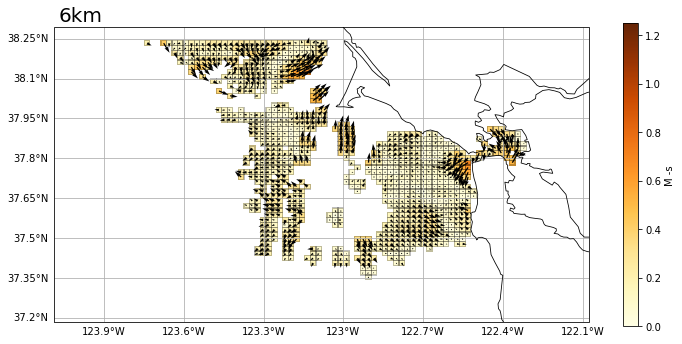

In [11]:
cmaps = ['YlOrBr','Reds', 'Greens', 'Purples',]
for i, ds in enumerate([ds_2k]):
    fig, ax = make_map()
    save_name = ['6km','2km','1km','500m']
    # Set the GeoAxes to the projection used by WRF

    # Add coastlines
    # # Add arrows to show the wind vectors !!!!
    x = ds.lon
    y = ds.lat
    x,y = np.meshgrid(x,y)

    u = ds.isel(time=0).u
    v = ds.isel(time=0).v
    spd = ds.isel(time=0).speed
    masked = np.ma.masked_array(spd.values, spd.values == np.nan)
    ax.pcolormesh(x, y, masked,vmin=1,vmax=1, alpha=0.25, zorder=2, facecolor='none', edgecolors='k', lw=.25,
           cmap='gray',transform=ccrs.PlateCarree())
    
    cax = plt.pcolormesh(x,y,masked,transform=ccrs.PlateCarree(),cmap=get_cmap(cmaps[0]),vmin=0,vmax=1.25,shading='nearest',snap=True)
    
    ax.grid(True, color="k", lw=2,zorder=10,alpha=.75)
    Q = plt.quiver( x, y, u, v, transform=ccrs.PlateCarree(), zorder=10, scale=10, units="xy")



    qk = plt.quiverkey(Q, 
                       0.025, -.1,                  # x,y label position
                       .5,
                       '0.5 M -s', # choose units + update string
                       labelpos='E',                # add label to the right
                       coordinates='axes'
                       )
    if save_name[i] == '1km':
        ax.set_xlim(-122.65,-122.25)
        ax.set_ylim(37.5,38.1)
    cbar = plt.colorbar(cax, shrink=.62)
    cbar.set_label('M -s')
    ax.text(.01,1.02,save_name[i],size=20,transform=ax.transAxes)
    plt.savefig('Figures/all_station_{}.png'.format(save_name[i]),dpi=300,bbox_inches='tight', pad_inches=0.25)

In [12]:
ds.isel(time=0)['time'].values

numpy.datetime64('2020-07-01T00:00:00.000000000')